<img src="img/saturn_logo.png" width="300" />

# Parallel Inference

We are ready to scale up our inference task!

<img src="https://media.giphy.com/media/4H5nOUqX7FywOGpCF7/giphy.gif" alt="scaleup" style="width: 200px;"/>


**Dataset:** [Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html)  
**Model:** [Resnet50](https://arxiv.org/abs/1512.03385)


We've done this before, but to refresh your memory, get connected to the cluster using the following code.

In [1]:
from dask_saturn import SaturnCluster
from dask.distributed import Client
from torchvision import datasets, transforms, models
import re

cluster = SaturnCluster(
)

client = Client(cluster)
client.wait_for_workers(3)
client

[2021-01-15 22:46:24] INFO - dask-saturn | Cluster is ready
[2021-01-15 22:46:24] INFO - dask-saturn | Registering default plugins
[2021-01-15 22:46:24] INFO - dask-saturn | {'tcp://10.0.17.22:43429': {'status': 'repeat'}, 'tcp://10.0.25.65:35279': {'status': 'repeat'}, 'tcp://10.0.27.164:33951': {'status': 'repeat'}}


Client Scheduler: tcp://d-steph-pytorch-b6b872e9b1c749d8adb771c003534759.main-namespace:8786 Dashboard: https://d-steph-pytorch-b6b872e9b1c749d8adb771c003534759.community.saturnenterprise.io,Cluster Workers: 3 Cores: 12 Memory: 46.50 GB


In [3]:
%run -i setup1.py

display(HTML(gpu_links))

We'll use the command above to get ourselves back to the state we need from Notebook 3.

***

## Assigning Objects to GPU Resources

If you are going to run any processes on GPU resources in a cluster, you need all your objects to be explicitly told this. Otherwise, it won't seek out GPU resources. However, if you use a functional setup (as we are going to do later) you'll need to do this INSIDE your function. Our architecture below will have all that written in. But before we go too complex, we should learn how that works in isolation.

This command is all you need to assign an object (a model, an image, etc) to a GPU-type resource. [The PyTorch docs can tell us more.](https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device) So here's how we do it with the model:

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)

resnet = resnet.to(device)

Now you try. What would you write to assign a transformed image (call it `img_t`) to a GPU resource? (*This image has already been created for you in the setup script.*)
We'll do this a few more times in the upcoming examples.

In [ ]:
type(img_t)

Fill in the blanks in between `<<< >>>` marks to get the correct code, or click the ellipsis below to check your work.

In [ ]:
### FILL IN THE BLANKS ###

img_t = <<< FILL IN >>>

In [ ]:
img_t = img_t.to(device)

## Preprocessing Images

Our goal here is to create a nicely streamlined workflow, including loading, transforming, batching, and labeling images, which we can then run in parallel.

In [5]:
import dask

@dask.delayed
def preprocess(path, fs=__builtins__):
    '''Ingest images directly from S3, apply transformations,
    and extract the ground truth and image identifier. Accepts
    a filepath. '''
    
    transform = transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(250), 
        transforms.ToTensor(),
    ])

    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        nvis = transform(img)

    truth = re.search('dogs/Images/n[0-9]+-([^/]+)/n[0-9]+_[0-9]+.jpg', path).group(1)
    name = re.search('dogs/Images/n[0-9]+-[a-zA-Z-_]+/(n[0-9]+_[0-9]+).jpg', path).group(1)
    
    return [name, nvis, truth]

This function does a number of things for us.
* Open an image file from S3
* Apply transformations to image
* Retrieve a unique identifier for the image
* Retrieve the ground truth label for the image

But you'll notice that this has a `@dask.delayed` decorator, so we can queue it without it running immediately when called. Because of this, we can use some list comprehension strategies to create our batches and get them ready for our inference.

First, we break the list of images we have from our S3 filepath into chunks that will define the batches. (We defined `s3` when we connected to the S3 file storage in [Notebook 3](03-single-inference.ipynb), if you forgot.)

***

### List Image Files

In [40]:
import toolz

s3fpath = 's3://saturn-public-data/dogs/Images/*/*.jpg'
batch_breaks = [list(batch) for batch in toolz.partition_all(80, s3.glob(s3fpath))]

In [41]:
len(batch_breaks)

258

In [42]:
batch_breaks[0][:5]

['saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_10074.jpg',
 'saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_10131.jpg',
 'saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_10621.jpg',
 'saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_1073.jpg',
 'saturn-public-data/dogs/Images/n02085620-Chihuahua/n02085620_10976.jpg']

What does one of our batches look like? It's a list of image paths!

***

## Process

In [43]:
image_batches = [[preprocess(x, fs=s3) for x in y] for y in batch_breaks]

In [44]:
image_batches[0][0].compute()

['n02085620_10074',
 tensor([[[0.1529, 0.1569, 0.1608,  ..., 0.1451, 0.1255, 0.1255],
          [0.1529, 0.1529, 0.1647,  ..., 0.1451, 0.1294, 0.1294],
          [0.1529, 0.1569, 0.1529,  ..., 0.1451, 0.1451, 0.1216],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.0275, 0.0275, 0.0275],
          [1.0000, 1.0000, 1.0000,  ..., 0.0275, 0.0275, 0.0275],
          [1.0000, 1.0000, 1.0000,  ..., 0.0275, 0.0275, 0.0275]],
 
         [[0.0863, 0.0902, 0.0941,  ..., 0.0667, 0.0745, 0.1255],
          [0.0863, 0.0863, 0.0980,  ..., 0.0667, 0.0863, 0.1451],
          [0.0863, 0.0902, 0.0863,  ..., 0.0549, 0.1059, 0.1569],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.0275, 0.0275, 0.0275],
          [1.0000, 1.0000, 1.0000,  ..., 0.0275, 0.0275, 0.0275],
          [1.0000, 1.0000, 1.0000,  ..., 0.0275, 0.0275, 0.0275]],
 
         [[0.0588, 0.0627, 0.0667,  ..., 0.0627, 0.0863, 0.1373],
          [0.0588, 0.0588, 0.0706,  ..., 0.0588, 0.0784, 0.1373],
          [0.0588, 0

### Reformat

<img src="img/batch-reformatting.png" width = 700>

In [45]:
@dask.delayed
def reformat(batch):
    flat_list = [item for item in batch]
    tensors = [x[1] for x in flat_list]
    names = [x[0] for x in flat_list]
    labels = [x[2] for x in flat_list]
    
    tensors = torch.stack(tensors).to(device)
    
    return [names, tensors, labels]

image_batches = [reformat(result) for result in image_batches] 

If we want to get a nice visual representation of the tasks we have queued up, we can use the `.visualize()` method on a delayed object, like this. We've set up a lot of tasks in this one batch!

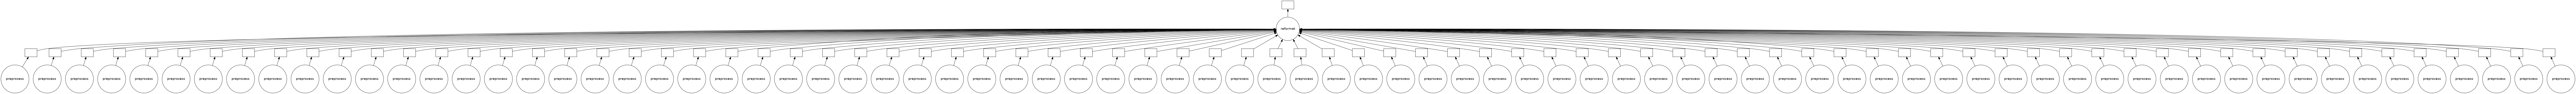

In [46]:
image_batches[0].visualize()

Now we have our images ready! But as you know, we really just have a list of tasks queued up that we're going to ask our cluster to complete later.

***

## Check Images

### Image Identifiers

In [58]:
test_set = image_batches[25][0][:5].compute()
test_set

['n02088238_2574',
 'n02088238_2646',
 'n02088238_2674',
 'n02088238_2686',
 'n02088238_2822']

In [59]:
image_batches[25][2][:5].compute()

['basset', 'basset', 'basset', 'basset', 'basset']

In [60]:
import matplotlib.pyplot as plt
cpudevice = torch.device("cpu")
tensorset = image_batches[25].compute()
to_pil = transforms.ToPILImage()

imglist = [to_pil(tensorset[1][0].to(cpudevice)), 
           to_pil(tensorset[1][1].to(cpudevice)),
           to_pil(tensorset[1][2].to(cpudevice)),
           to_pil(tensorset[1][3].to(cpudevice)),
           to_pil(tensorset[1][4].to(cpudevice))]

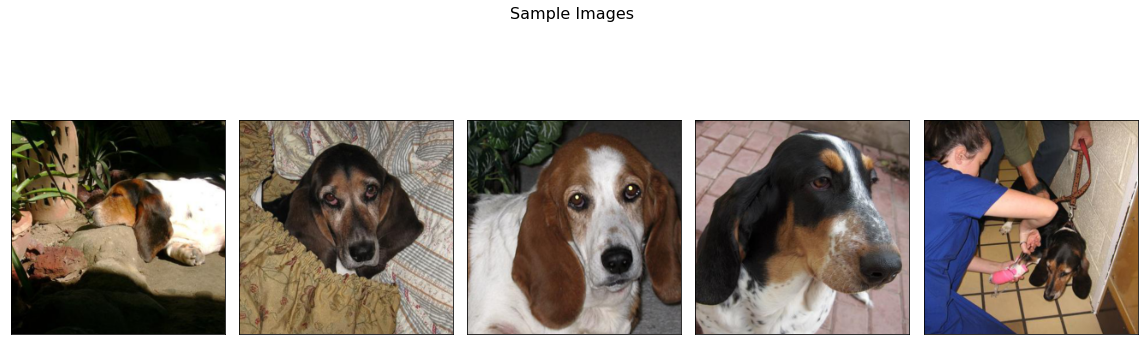

In [61]:
f, ax = plt.subplots(1, 5, figsize=(16,6))

for i in range(0,5):
    img1 = imglist[i]
    ax[i].imshow(img1).axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

title = 'Sample Images'
f.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()


***

## Run the Model
We are ready to do the inference task! This is going to have a few steps, all of which are contained in functions described below, but we’ll talk through them so everything is clear, using just one batch as an example.

Our unit of work at this point is batches of 60 images at a time, which we created in the section above. They are all neatly arranged in lists so that we can work with them effectively.


***

## Result Evaluation

The predictions and truth we have so far, however, are not really human readable or comparable, so we’ll use the functions that follow to fix them up and get us interpretable results.

In [17]:
def evaluate_pred_batch(batch, gtruth, classes):
    ''' Accepts batch of images, returns human readable predictions. '''
    
    _, indices = torch.sort(batch, descending=True)
    percentage = torch.nn.functional.softmax(batch, dim=1)[0] * 100
    
    preds = []
    labslist = []
    for i in range(len(batch)):
        pred = [(classes[idx], percentage[idx].item()) for idx in indices[i][:1]]
        preds.append(pred)

        labs = gtruth[i]
        labslist.append(labs)
        
    return(preds, labslist)

def is_match(label, pred):
    ''' Evaluates human readable prediction against ground truth.'''
    if re.search(label.replace('_', ' '), str(pred).replace('_', ' ')):
        match = True
    else:
        match = False
    return(match)

This takes our results from the model, and a few other elements, to return nice readable predictions and the probabilities the model assigned. From here, we’re nearly done! We want to pass our results back to S3 in a tidy, human readable way, so the rest of the function handles that. It will iterate over each image because these functionalities are not batch handling. `is_match` is one of our custom functions, which you can check out below.



## Put It All Together

Now, we aren’t going to patch together all these computations by hand, instead we have assembled them in one single delayed function that will do the work for us. Importantly, we can then map this across all our batches of images across the cluster! Can you spot all the tasks we have described above? 

Fill in the blanks in between `<<< >>>` marks to get the correct code, or click the ellipsis below to check your work.

In [ ]:
### FILL IN THE BLANKS ###

@dask.delayed
def run_batch_to_s3(iteritem):
    ''' Accepts iterable result of preprocessing, generates
    inferences and evaluates. '''
  
    names, images, truelabels = iteritem
    
    with s3.open('s3://saturn-public-data/dogs/imagenet1000_clsidx_to_labels.txt') as f:
        classes = [line.strip() for line in f.readlines()]

    # Retrieve, set up model
    resnet = <<< FILL IN >>>
    resnet = resnet.to(device)

    with torch.no_grad():
        resnet.<<< FILL IN >>>
        pred_batch = <<< FILL IN >>>(images)
        
        #Evaluate batch
        preds, labslist = evaluate_pred_batch(pred_batch, truelabels, classes)

        #Organize prediction results
        outcomes = []
        for j in range(0, len(images)):
            match = is_match(labslist[j], preds[j])            
            outcome = {'name': names[j], 'ground_truth': labslist[j], 
                       'prediction': preds[j], 'evaluation': match}
            outcomes.append(outcome)
    
        return(outcomes)

In [18]:
@dask.delayed
def run_batch_to_s3(iteritem):
    ''' Accepts iterable result of preprocessing, generates
    inferences and evaluates. '''
  
    names, images, truelabels = iteritem
    
    with s3.open('s3://saturn-public-data/dogs/imagenet1000_clsidx_to_labels.txt') as f:
        classes = [line.strip() for line in f.readlines()]

    # Retrieve, set up model
    resnet = models.resnet50(pretrained=True)
    resnet = resnet.to(device)

    with torch.no_grad():
        resnet.eval()
        pred_batch = resnet(images)
        
        #Evaluate batch
        preds, labslist = evaluate_pred_batch(pred_batch, truelabels, classes)

        #Organize prediction results
        outcomes = []
        for j in range(0, len(images)):
            match = is_match(labslist[j], preds[j])            
            outcome = {'name': names[j], 'ground_truth': labslist[j], 
                       'prediction': preds[j], 'evaluation': match}
            outcomes.append(outcome)
    
        return(outcomes)

## Run the Job

If you think you've filled in everything correctly, now you can try running the tasks in parallel. If you get errors, check the hidden chunk for answers.

Notice that we're going to use client methods below to ensure that our tasks are distributed across the cluster, run, and then retrieved.

In [19]:
display(HTML(gpu_links))

In [20]:
%%time

futures = client.map(run_batch_to_s3, image_batches) 
futures_gathered = client.gather(futures)
futures_computed = client.compute(futures_gathered, sync=False)

import logging

results = []
errors = []
for fut in futures_computed:
    try:
        result = fut.result()
    except Exception as e:
        errors.append(e)
        logging.error(e)
    else:
        results.extend(result)

CPU times: user 15.5 s, sys: 279 ms, total: 15.8 s
Wall time: 2min 59s


When we run this block, we might want to go visit the Dask dashboard, to see our work as it runs.


***

## Review Results

Look at the graph for one batch, and spot check output.

In [ ]:
test_sample = run_batch_to_s3(image_batches[0])
test_sample.visualize(rankdir="LR")

In [54]:
futures_computed[0].result()[0]

{'name': 'n02085620_10074',
 'ground_truth': 'Chihuahua',
 'prediction': [(b"151: 'Chihuahua',", 93.02685546875)],
 'evaluation': True}

In [55]:
results[0]

{'name': 'n02085620_10074',
 'ground_truth': 'Chihuahua',
 'prediction': [(b"151: 'Chihuahua',", 93.02685546875)],
 'evaluation': True}

### Check Original Sample

In [62]:
test_dogs = [d for d in results if d['name'] in test_set]
test_dogs

[{'name': 'n02088238_2574',
  'ground_truth': 'basset',
  'prediction': [(b"161: 'basset, basset hound',", 58.23561096191406)],
  'evaluation': True},
 {'name': 'n02088238_2646',
  'ground_truth': 'basset',
  'prediction': [(b"161: 'basset, basset hound',", 58.23561096191406)],
  'evaluation': True},
 {'name': 'n02088238_2674',
  'ground_truth': 'basset',
  'prediction': [(b"161: 'basset, basset hound',", 58.23561096191406)],
  'evaluation': True},
 {'name': 'n02088238_2686',
  'ground_truth': 'basset',
  'prediction': [(b"161: 'basset, basset hound',", 58.23561096191406)],
  'evaluation': True},
 {'name': 'n02088238_2822',
  'ground_truth': 'basset',
  'prediction': [(b"162: 'beagle',", 28.528362274169922)],
  'evaluation': False}]

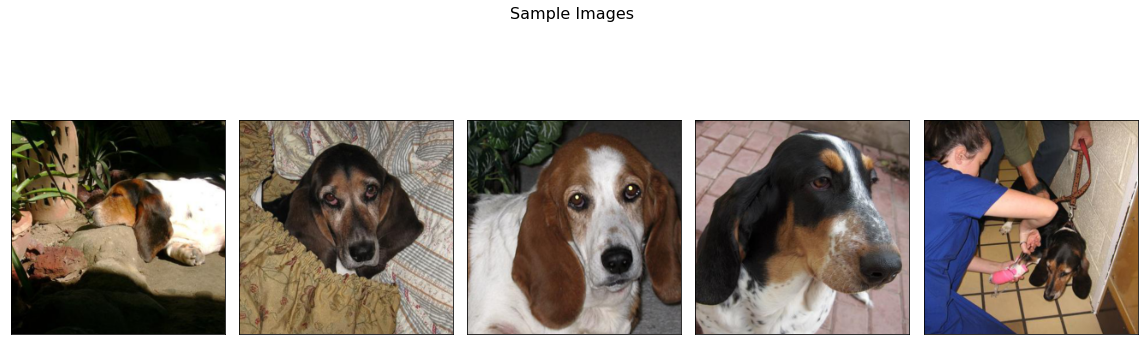

In [63]:
f, ax = plt.subplots(1, 5, figsize=(16,6))

for i in range(0,5):
    img1 = imglist[i]
    ax[i].imshow(img1).axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

title = 'Sample Images'
f.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()

***

## Overall Accuracy

In [26]:
len(results)

20580

In [36]:
true_preds = [x['evaluation'] for x in results if x['evaluation'] == True]
false_preds = [x['evaluation'] for x in results if x['evaluation'] == False]

In [39]:
len(true_preds)/len(results)*100

67.06511175898932

***

## Lessons Learned

* You can apply `@dask.delayed` to your custom code to allow parallelization with nearly zero refactoring
* Objects that are needed for a parallel task on GPU need to be assigned to a GPU resource
* Passing tasks to the workers uses mapping across the cluster for peak efficiency

And, of course, having multiple workers makes the job a lot faster!

<img src="https://media.giphy.com/media/Ood1OSF92jubS/giphy.gif" alt="parallel" style="width: 250px;"/>

